# Regression from ch 4

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import seaborn as sns
import pymc3 as pm
import pandas as pd

%matplotlib inline
sns.set(font_scale=1.5)

Text(0.5, 0, '$y$')

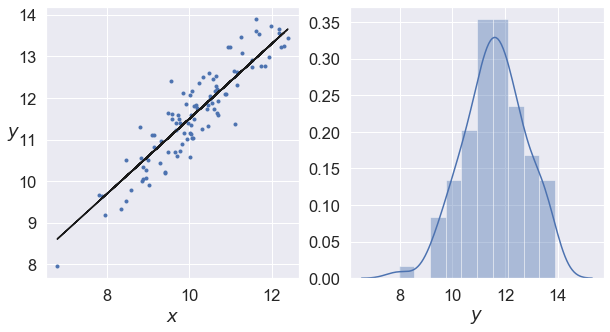

In [2]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)
x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(x, y, 'b.')
plt.xlabel('$x$', )
plt.ylabel('$y$', rotation=0)
plt.plot(x, y_real, 'k')
plt.subplot(1,2,2)
sns.distplot(y)
plt.xlabel('$y$')

In [ ]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    #mu = pm.Deterministic('mu', alpha + beta * x)
    #y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    y_pred = pm.Normal('y_pred', mu= alpha + beta * x, sd=epsilon, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, chains=2)

In [ ]:
pm.traceplot(trace, compact=True);

### This slow wandering in alpha and beta shows an issue!

In [ ]:
pm.summary(trace, var_names=('alpha', 'beta', 'epsilon'))

In [ ]:
pm.plot_posterior(trace, var_names=('alpha', 'beta', 'epsilon'));

In [ ]:
pm.autocorrplot(trace, var_names=('alpha', 'beta', 'epsilon'));

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

## Does NUTS do better?

In [ ]:
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    #mu = pm.Deterministic('mu', alpha + beta * x)
    #y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    y_pred = pm.Normal('y_pred', mu= alpha + beta * x, sd=epsilon, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, chains=2)

### No!

In [ ]:
pm.traceplot(trace, compact=True);

In [ ]:
pm.autocorrplot(trace, var_names=('alpha', 'beta', 'epsilon'));

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

### Try subtracting the mean

In [ ]:
xmean = np.mean(x)
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=1)
    epsilon = pm.HalfCauchy('epsilon', 5)
    #mu = pm.Deterministic('mu', alpha + beta * x)
    #y_pred = pm.Normal('y_pred', mu=mu, sd=epsilon, observed=y)
    y_pred = pm.Normal('y_pred', mu= alpha + beta * (x-xmean), sd=epsilon, observed=y)
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step, chains=2)

In [ ]:
pm.traceplot(trace, compact=True);

In [ ]:
pm.autocorrplot(trace, var_names=('alpha', 'beta', 'epsilon'));

In [ ]:
plt.figure(figsize=(10,6))
sns.kdeplot(trace['alpha'], trace['beta'])
plt.xlabel(r'$\alpha$', fontsize=16)
plt.ylabel(r'$\beta$', fontsize=16, rotation=0)

In [ ]:
pm.plot_ppc(trace)

In [ ]:
plt.plot(x, y, 'b.');
alpha_m = trace['alpha'].mean()
beta_m = trace['beta'].mean()
alpha = alpha_m+beta_m*x
plt.plot(x, alpha + beta_m * x, c='k', ) #label='y = {:.2f} + {:.2f} * x'.format(alpha, beta_m))
plt.xlabel('$x$', fontsize=16)
plt.ylabel('$y$', fontsize=16, rotation=0)
plt.legend(loc=2, fontsize=14)

In [ ]:
alpha

In [ ]:
alpha, beta_m

# Look to problmatic data sets
page 114+


In [3]:
import os
v = [v for v in os.environ if 'proxy' in v]
for vv in v:
    del os.environ[vv]
    print(vv)


http_proxy
ftp_proxy
https_proxy


In [4]:
sns.get_dataset_names()

/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/utils.py:376: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 376 of the file /Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/seaborn/utils.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  gh_list = BeautifulSoup(http)


['anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'iris',
 'mpg',
 'planets',
 'tips',
 'titanic']

In [20]:
ans = sns.load_dataset('anscombe')
X = ans[ans.dataset == 'III']['x'].values
Y = ans[ans.dataset == 'III']['y'].values
ind = np.argsort(X)
X = X[ind]
Y = Y[ind]

In [21]:
# X = np.arange(10)+np.random.normal(0, .1, size=10)
# Y = 5*X + 10 + np.random.normal(0, 3, size=10)
# Y[7] += 50

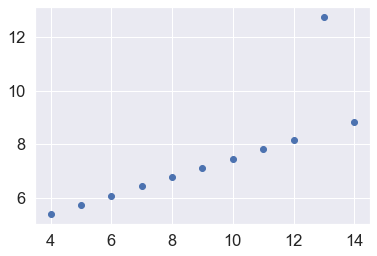

In [22]:
plt.scatter(X,Y)

In [23]:
data = pd.DataFrame({'x':X, 'y':Y})
with pm.Model() as model:
    glm_n = pm.glm.GLM.from_formula('y ~ x', data)
    trace_n = pm.sample(2000) # draw 2000 posterior samples using NUTS sampling

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sd, x, Intercept]
Sampling 2 chains: 100%|██████████| 5000/5000 [00:04<00:00, 1002.82draws/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6961320588634954, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


In [24]:
glm_n

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a10b850>,
      dtype=object)

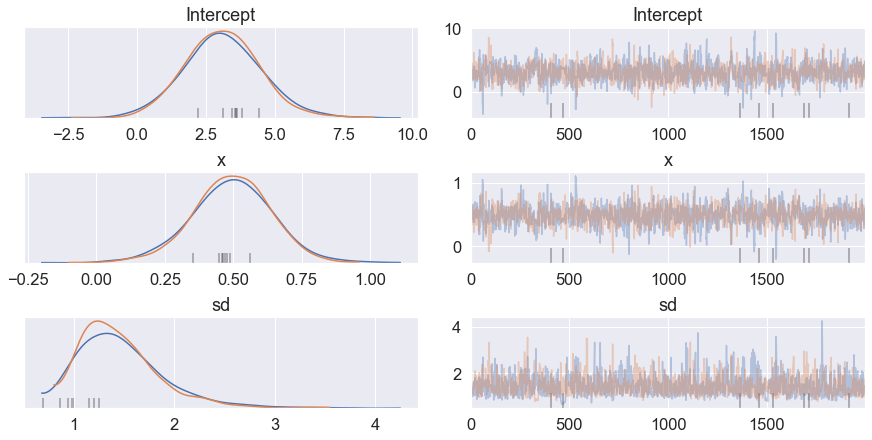

In [25]:
pm.traceplot(trace_n)

In [26]:
ppc_n = pm.sample_posterior_predictive(trace_n, samples=500, model=model, )


100%|██████████| 500/500 [00:00<00:00, 1096.39it/s]


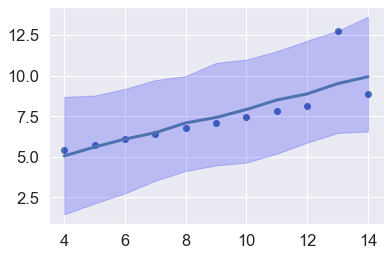

In [27]:
plt.scatter(X,Y)
perc_n = np.percentile(ppc_n['y'], [2.5, 97.5, 50], axis=0)
plt.fill_between(X, perc_n[0], perc_n[1], color='blue', alpha=0.2)
plt.plot(X, perc_n[2], lw=3)

In [28]:
data = pd.DataFrame({'x':X, 'y':Y})
with pm.Model() as model:
    glm_t = pm.glm.GLM.from_formula('y ~ x', data, family=pm.families.StudentT())
    step = pm.Metropolis()
#     step = pm.NUTS()
    trace_t = pm.sample(10000, step=step, tune=5000) # draw 2000 posterior samples using NUTS sampling

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [lam]
>Metropolis: [x]
>Metropolis: [Intercept]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:06<00:00, 4374.11draws/s]
The number of effective samples is smaller than 10% for some parameters.


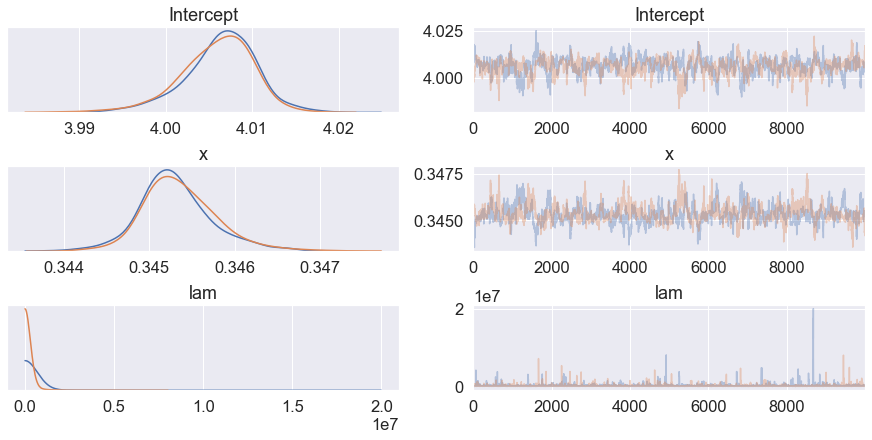

In [29]:
pm.traceplot(trace_t);

In [30]:
pm.summary(trace_t)

/Users/balarsen/miniconda3/envs/python3/lib/python3.7/site-packages/pymc3/stats.py:991: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
Intercept,4.006153,0.004142,0.000245,3.997196,4.013810,218.395500,1.005781
x,0.345337,0.000442,0.000026,0.344506,0.346294,217.963477,1.006414
lam,175869.515211,416312.044282,9550.441922,2148.293841,544186.453644,2051.814645,1.000113


In [31]:
glm_t

100%|██████████| 1000/1000 [00:00<00:00, 1044.85it/s]


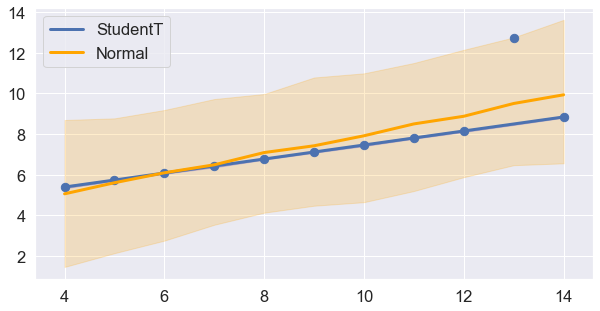

In [32]:
fig, ax = plt.subplots(figsize=(10,5))

ppc_t = pm.sample_posterior_predictive(trace_t, samples=1000, model=model, )
perc_t = np.percentile(ppc_t['y'], [2.5, 97.5, 50], axis=0)
plt.fill_between(X, perc_t[0], perc_t[1], color='blue', alpha=0.2)
plt.fill_between(X, perc_n[0], perc_n[1], color='orange', alpha=0.2)

plt.plot(X, perc_t[2], lw=3, label='StudentT')
plt.plot(X, perc_n[2], lw=3, label='Normal', color='orange')
plt.scatter(X,Y, s=70)
plt.legend(loc='upper left')

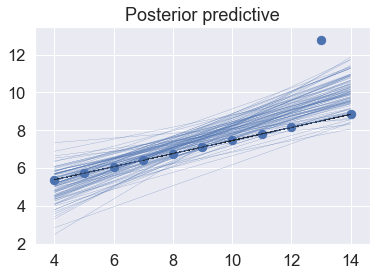

In [33]:
pm.plot_posterior_predictive_glm(trace_t, eval=X, samples=100)
pm.plot_posterior_predictive_glm(trace_n, eval=X, samples=100, color='b')

plt.scatter(X,Y, s=70)


In [34]:
data = pd.DataFrame({'x':X, 'y':Y})
with pm.Model() as model:
    glm_ts = pm.glm.GLM.from_formula('y ~ standardize(x)', data, family=pm.families.StudentT())
    step = pm.Metropolis()
#     step = pm.NUTS()
    trace_ts = pm.sample(10000, step=step, tune=5000) # draw 2000 posterior samples using NUTS sampling

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [lam]
>Metropolis: [standardize(x)]
>Metropolis: [Intercept]
Sampling 2 chains: 100%|██████████| 30000/30000 [00:06<00:00, 4507.52draws/s]
The number of effective samples is smaller than 25% for some parameters.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c386446d0>,
      dtype=object)

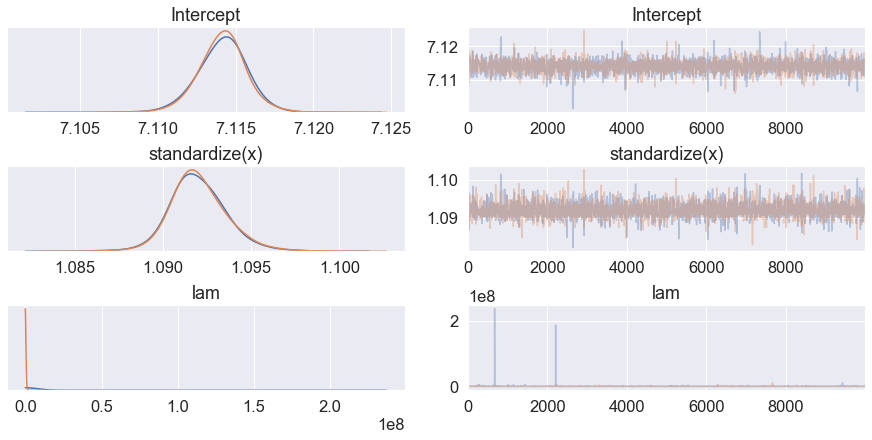

In [36]:
pm.traceplot(trace_ts)

100%|██████████| 1000/1000 [00:00<00:00, 1194.09it/s]


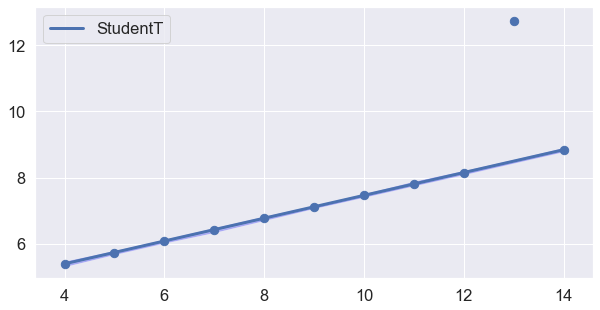

In [37]:
fig, ax = plt.subplots(figsize=(10,5))

ppc_ts = pm.sample_posterior_predictive(trace_ts, samples=1000, model=model, )
perc_ts = np.percentile(ppc_ts['y'], [2.5, 97.5, 50], axis=0)
plt.fill_between(X, perc_ts[0], perc_t[1], color='blue', alpha=0.2)

plt.plot(X, perc_ts[2], lw=3, label='StudentT')
plt.scatter(X,Y, s=70)
plt.legend(loc='upper left')

In [39]:
pm.plot_posterior_predictive_glm(trace_ts, eval=X, samples=100)


KeyError: 'x'